# Letter Recognition CNN

Willard Bui

## Project Description

This project aims to create a convolutional neural network (CNN) for the task of letter recognition. The task of letter recognition, or more generally speaking, text recognition (also known as optical character recognition, or OCR) has gained much importance in recent years due to emerging applications. For example, OCR software can be used to convert handwritten text into digital text and robots use cameras to read signs in their environment. Letter recognition is a subtask of text recognition with wide applications as well - iPhones use letter recognition to convert handwritten characters to text. Due to the increasing importance of these tasks, we aim to create a robust CNN that is able to correctly classify handwritten and digital letters.

_Note: the statistics in this notebook differ from the statistics provided in the final presentation because this notebook was rerun before the final submission._

In [1]:
# Run these two lines to load important libraries and set things up
from letter_recognition_functions import *
from ttf_to_png import *
%matplotlib inline

## Dataset

We collected handwritten letters from 23 students, each of whom wrote the alphabet 10 times. This gave us about 6K data points to train and test our model.

In [2]:
letter_to_label = dict()
classes = ['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
for i in range(len(classes)):
    letter_to_label[classes[i]] = i
print(letter_to_label)

{'N/A': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}


A conversion script was used to convert all ttfs to pngs. The script can be found in `ttf_to_png.py`. The block below can be used to run the conversion script. If you would like to run this script, please install imagemagick using `brew install imagemagick`. Please note that there could be more dependencies that you may need to install based on the system this script is run under. 

_Note: we only provide one ttf per person even though each person gave 10 samples in the interest of space. Consequenlty, we only provide one png per person in the dataset. Similarly, only a truncated dataset and relevant pngs for the digital fonts are provided. This was done to keep the size of the submission low. Consequenlty, if this notebook is run again, the output is subject to change._

In [ ]:
# src_dir = 'data/collected_ttfs'
# dst_dir = 'data/collected_letters_pngs'
# convert_ttf(src_dir, dst_dir)

In [5]:
num_participants = 23
src_dir = 'data/collected_letters_png'
transform = transforms.ToTensor()

num_train = int(0.7 * num_participants)
num_val = (num_participants - num_train) // 2

imgs_train = []
imgs_val = []
imgs_test = []
labels_train = []
labels_val = []
labels_test = []
for f in glob.glob(os.path.join(src_dir, '*.png')):
    ftitle, fext = os.path.splitext(os.path.basename(f))
    letter = ftitle.split("_")[1].lower()
    # gets which person wrote this font
    p_val = int(ftitle.split("_")[0].split("-")[0][1:])
    im = Image.open(f).convert('L')
    
    if p_val <= num_train:
        imgs_train += transform(im).detach().tolist()
        labels_train.append(letter_to_label[letter])
    elif p_val <= num_train + num_val:
        imgs_val += transform(im).detach().tolist()
        labels_val.append(letter_to_label[letter])
    else:
        imgs_test += transform(im).detach().tolist()
        labels_test.append(letter_to_label[letter])

In [7]:
train_loader_collected = create_loader(imgs_train, labels_train)
val_loader_collected = create_loader(imgs_val, labels_val)
test_loader_collected = create_loader(imgs_test, labels_test)

Label: c


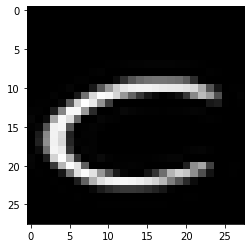

In [8]:
# Visualization for our collected dataset
img, label = get_input(train_loader_collected)
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')
print("Label: %s" % classes[label])

## Defining a basic LetterCNN

We define a basic CNN with 1 convolutional layer, 1 MaxPool layer, a ReLU activation and finally a fully connected layer for our model. This model will be used throughout our prelimenary expriments (i.e. before our computational experiments).

In [9]:
class letterCNN(nn.Module):
    def __init__(self, classes):
        super().__init__()
        self.classes = classes
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(5,5), stride=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1152, len(self.classes))
        )
            
    def forward(self, x):
        output = self.layers(x)
        return output

## Testing the basic LetterCNN

In [10]:
basic_model_collected = letterCNN(classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(basic_model_collected.parameters(), lr=1e-3)
train_network(basic_model_collected, train_loader_collected, val_loader_collected, criterion, optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 2.03967
   Val loss: 2.27518

EPOCH 1
 Train loss: 1.08935
   Val loss: 2.53252

EPOCH 2
 Train loss: 0.76793
   Val loss: 2.42388

EPOCH 3
 Train loss: 0.52004
   Val loss: 2.74752

EPOCH 4
 Train loss: 0.33532
   Val loss: 2.91625

EPOCH 5
 Train loss: 0.22409
   Val loss: 2.96997

EPOCH 6
 Train loss: 0.14334
   Val loss: 3.06981

EPOCH 7
 Train loss: 0.09882
   Val loss: 3.29160

EPOCH 8
 Train loss: 0.06873
   Val loss: 3.34099

EPOCH 9
 Train loss: 0.04989
   Val loss: 3.52233



Test accuracy: 53.846


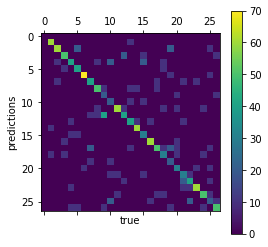

In [11]:
acc, true, pred = test_network(basic_model_collected, test_loader_collected)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(basic_model_collected.classes), pred, true)

We see quite a bit of overfitting (since the validation loss is not converging and, in fact, even increasing). This naturally causes our accuracy to be quite low. While this accuracy is still quite good - $0.53846 / (1 / 26) = 13.99$ times increase in accuracy from just taking a random guess - we can still do better. The reason for this poor performance is because only a few people's data was obtained. This causes our model to be biased towards the the handwriting of a few people and prevents it from generalizing well. Thus, we will combine our dataset with the EMNIST dataset to create a better model.

## EMNIST Dataset

In [12]:
# Download the EMNIST dataset and load it as tensors
from torchvision import datasets, transforms

save_dir = 'EMNIST'

transform = transforms.ToTensor() # Convert the image into a torch tensor.

train_set = datasets.EMNIST(save_dir, split="letters", download=True, train=True, transform=transform)
test_set = datasets.EMNIST(save_dir, split="letters", download=True, train=False, transform=transform)

print(train_set)
print(test_set)

Dataset EMNIST
    Number of datapoints: 124800
    Root location: EMNIST
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset EMNIST
    Number of datapoints: 20800
    Root location: EMNIST
    Split: Test
    StandardTransform
Transform: ToTensor()


In [13]:
# Create samplers for the training and validation sets
from torch.utils.data.sampler import SubsetRandomSampler

ntotal = 60000
ntrain = int(0.70*ntotal)
nval = ntotal - ntrain

val_ix = np.random.choice(range(ntotal), size=nval, replace=False)
train_ix = list(set(range(ntotal)) - set(val_ix))

train_sampler = SubsetRandomSampler(train_ix)
val_sampler = SubsetRandomSampler(val_ix)

In [14]:
# initialize the data sets
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

Label: o


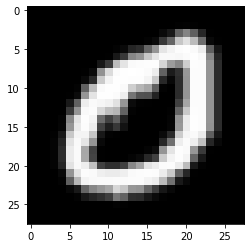

In [15]:
# Visualization EMNIST
img, label = get_input(train_loader)
# print label
index = 0
plt.imshow(img.reshape((28, 28)).T, cmap='Greys_r')
print("Label: %s" % classes[label])

## Combining EMNIST with our Data

In [16]:
combined_train_loader = combine_loaders(train_loader, train_loader_collected, fromEMNIST=True)
combined_val_loader = combine_loaders(val_loader, val_loader_collected, fromEMNIST=True)
combined_test_loader = combine_loaders(test_loader, test_loader_collected, fromEMNIST=True)

Label: z


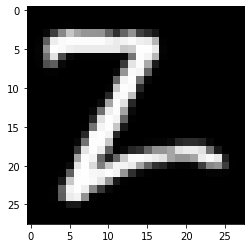

In [17]:
# Verifying combined
img, label = get_input(combined_test_loader)
# print label
index = 0
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')
print("Label: %s" % classes[label])

## Making a new LetterCNN on the Combined Dataset

In [18]:
basic_model = letterCNN(classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(basic_model.parameters(), lr=1e-3)
train_network(basic_model, combined_train_loader, combined_val_loader, criterion, optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 1.19218
   Val loss: 0.78986

EPOCH 1
 Train loss: 0.66488
   Val loss: 0.66060

EPOCH 2
 Train loss: 0.54276
   Val loss: 0.62709

EPOCH 3
 Train loss: 0.47431
   Val loss: 0.60437

EPOCH 4
 Train loss: 0.42339
   Val loss: 0.58524

EPOCH 5
 Train loss: 0.38831
   Val loss: 0.56671

EPOCH 6
 Train loss: 0.35752
   Val loss: 0.55615

EPOCH 7
 Train loss: 0.33534
   Val loss: 0.54937

EPOCH 8
 Train loss: 0.31865
   Val loss: 0.55207

EPOCH 9
 Train loss: 0.30385
   Val loss: 0.55290



Test accuracy: 84.030


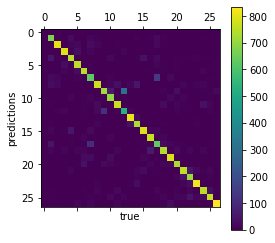

In [19]:
acc, true, pred = test_network(basic_model, combined_test_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(basic_model.classes), pred, true)

We see immediate improvement in our results. The new model does not overfit (since the validation loss decreases) and generalizes quite well, giving us an accuracy of about 84.03%, an increase of about 30.18% in accuracy compared to our older model. This shows that our model works well if a good dataset is provided. 

## Computational Experiment 1 - Regularization

Our first set of computational experiments will deal with better regularization of our model in hopes of creating a more generalized model. 

In [ ]:
# Run this block if you would like to convert the provided ttfs for fonts to pngs
# src_dir = 'data/digital_ttfs'
# dst_dir = 'data/digital_letters_pngs'
# convert_ttf(src_dir, dst_dir)

### 1a) Regularization through data augmentation - add digital fonts

For this experiment, we add digital fonts to our dataset. Specifically, we take 138 different fonts and add their characters to our dataset. We hypothesize that this will increase the accuracy of our model.

In [20]:
src_dir = "data/digital_letters_pngs"
num_fonts = 138

num_train = int(0.7 * num_fonts)
num_val = (num_fonts - num_train) // 2

imgs_train = []
imgs_val = []
imgs_test = []
labels_train = []
labels_val = []
labels_test = []
idx = 0
for f in glob.glob(os.path.join(src_dir, '*.png')):
    ftitle, fext = os.path.splitext(os.path.basename(f))
    letter = ftitle.split("_")[1].lower()
    im = Image.open(f).convert('L')

    if idx < num_train:
        imgs_train += transform(im).detach().tolist()
        labels_train.append(letter_to_label[letter])
    elif idx < num_train + num_val:
        imgs_val += transform(im).detach().tolist()
        labels_val.append(letter_to_label[letter])
    else:
        imgs_test += transform(im).detach().tolist()
        labels_test.append(letter_to_label[letter])
    
    idx += 1

In [21]:
train_loader_digital = create_loader(imgs_train, labels_train)
val_loader_digital = create_loader(imgs_val, labels_val)
test_loader_digital = create_loader(imgs_test, labels_test)

Label: q


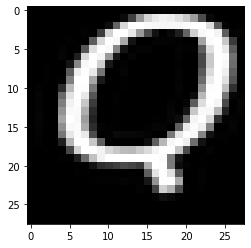

In [22]:
# Visualization of a digital font
img, label = get_input(train_loader_digital)
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')
print("Label: %s" % classes[label])

In [23]:
# Combine digital with other data
combined_train_digital_loader = combine_loaders(combined_train_loader, train_loader_digital)
combined_val_digital_loader = combine_loaders(combined_val_loader, val_loader_digital)
combined_test_digital_loader = combine_loaders(combined_test_loader, test_loader_digital)

Label: f


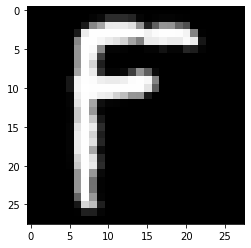

In [24]:
# Verifiying combined
img, label = get_input(combined_test_digital_loader)
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')
print("Label: %s" % classes[label])

In [27]:
# Train model with augmented data
model_digital = letterCNN(classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_digital.parameters(), lr=1e-3)
train_network(model_digital, combined_train_digital_loader, combined_val_digital_loader, criterion, optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 1.40823
   Val loss: 0.98178

EPOCH 1
 Train loss: 0.79560
   Val loss: 0.71478

EPOCH 2
 Train loss: 0.59182
   Val loss: 0.64586

EPOCH 3
 Train loss: 0.50447
   Val loss: 0.61768

EPOCH 4
 Train loss: 0.45356
   Val loss: 0.59527

EPOCH 5
 Train loss: 0.41630
   Val loss: 0.57307

EPOCH 6
 Train loss: 0.38708
   Val loss: 0.57452

EPOCH 7
 Train loss: 0.36602
   Val loss: 0.56370

EPOCH 8
 Train loss: 0.34433
   Val loss: 0.55416

EPOCH 9
 Train loss: 0.32635
   Val loss: 0.56883



Test accuracy: 78.541


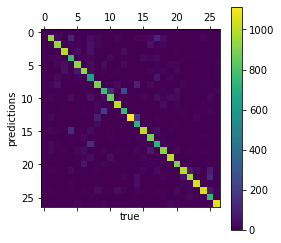

In [28]:
acc, true, pred = test_network(model_digital, combined_test_digital_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model_digital.classes), pred, true)

The accuracy of the model with the augmented data did not improve (in fact, it decreased by about 5.49%). It is possible that this happened because we only included 138 fonts - we believe that including more fonts in our dataset should improve the accuracy of our model. However, given current results, it is reasonable to say that the improvement in accuracy will not be very significant even if more fonts are added. 

### 1b) Regularization through dropout

We hypothesize that adding dropout will decrease the accuracy of our model because each image is simply a 28 x 28 image of a letter, and dropping out even the smallest learned feature for a small image should impact the accuracy negatively.

In [29]:
class letterCNNDropout(nn.Module):
    def __init__(self, classes):
        super().__init__()
        self.classes = classes
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(5,5), stride=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Dropout(p=0.2),
            nn.Linear(1152, len(self.classes))
        )
            
    def forward(self, x):
        output = self.layers(x)
        return output

In [30]:
model_dropout = letterCNNDropout(classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_dropout.parameters(), lr=1e-3)
train_network(model_dropout, combined_train_loader, combined_val_loader, criterion, optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 1.34002
   Val loss: 0.94478

EPOCH 1
 Train loss: 0.81660
   Val loss: 0.80049

EPOCH 2
 Train loss: 0.67909
   Val loss: 0.73220

EPOCH 3
 Train loss: 0.60601
   Val loss: 0.70227

EPOCH 4
 Train loss: 0.56011
   Val loss: 0.68391

EPOCH 5
 Train loss: 0.52107
   Val loss: 0.66330

EPOCH 6
 Train loss: 0.48975
   Val loss: 0.66835

EPOCH 7
 Train loss: 0.46952
   Val loss: 0.64259

EPOCH 8
 Train loss: 0.45230
   Val loss: 0.63604

EPOCH 9
 Train loss: 0.43254
   Val loss: 0.62947



Test accuracy: 82.150


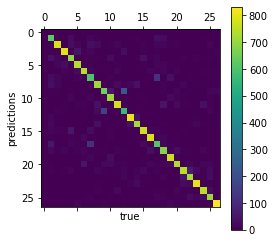

In [31]:
acc, true, pred = test_network(model_dropout, combined_test_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model_dropout.classes), pred, true)

As hypothesized, the accuracy of our model did drop using dropout.

### 1c) Regularization through Average Pooling

We hypothesize that the accuracy of our model will stay about the same with average pooling. We believe this to be the case because we have a network with just one convolutional layer which learns on fairly small images. 

Label: k


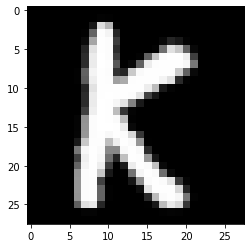

In [32]:
# Visualizing the combined dataset 
img, label = get_input(combined_train_loader)
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')
print("Label: %s" % classes[label])

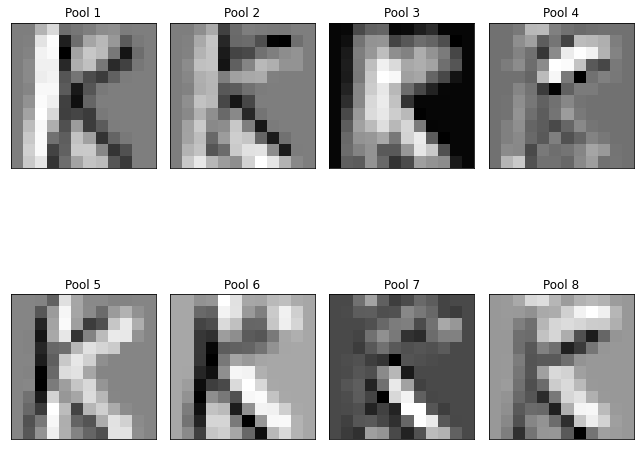

In [33]:
# visualize convolved kernels with max pooling
conv_out = basic_model.layers[0](img)
_ = display_pool_outputs(basic_model.layers[1], conv_out)

We see that the convolved kernels are not very smooth. This is to be expected as a result of max pooling. The convolved kernels with average pooling should be a little smoother. 

In [34]:
class letterCNNAvgPool(nn.Module):
    def __init__(self, classes):
        super().__init__()
        self.classes = classes
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(5,5), stride=1),
            nn.AvgPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1152, len(self.classes))
        )
            
    def forward(self, x):
        output = self.layers(x)
        return output

In [35]:
model_avgpool = letterCNNAvgPool(classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_avgpool.parameters(), lr=1e-3)
train_network(model_avgpool, combined_train_loader, combined_val_loader, criterion, optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 1.50045
   Val loss: 1.14755

EPOCH 1
 Train loss: 0.98683
   Val loss: 0.85010

EPOCH 2
 Train loss: 0.72796
   Val loss: 0.74292

EPOCH 3
 Train loss: 0.59939
   Val loss: 0.68052

EPOCH 4
 Train loss: 0.52339
   Val loss: 0.65055

EPOCH 5
 Train loss: 0.47118
   Val loss: 0.63163

EPOCH 6
 Train loss: 0.43494
   Val loss: 0.62232

EPOCH 7
 Train loss: 0.40765
   Val loss: 0.61087

EPOCH 8
 Train loss: 0.38204
   Val loss: 0.61404

EPOCH 9
 Train loss: 0.36061
   Val loss: 0.61065



Test accuracy: 82.788


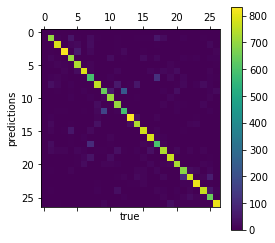

In [36]:
acc, true, pred = test_network(model_avgpool, combined_test_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model_avgpool.classes), pred, true)

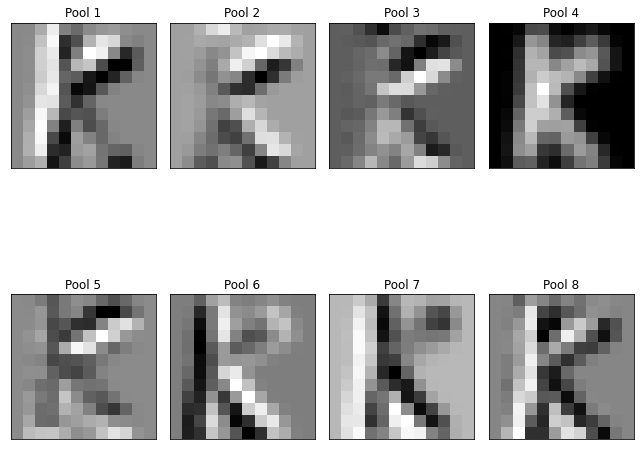

In [37]:
# visualize convolved kernels of the CNN with average pooling
conv_out = model_avgpool.layers[0](img)
_ = display_pool_outputs(model_avgpool.layers[1], conv_out)

The convoled kernels for average pooling are smoother than the convolved kernels for max pooling, as expected. As hypothesized, the accuracy of our model did not improve with average pooling. However, it is interesting that the accuracy decreased a bit with average pooling. This suggests that, for the task of letter recognition, max pooling is a better strategy than average pooling. 

### 1d) Regularization through Early Stopping

As our final experiment for the first computational experiment, we implement early stopping. We hypothesize that early stopping should improve the accuracy marginally. 

In [38]:
model_early_stopping = letterCNN(classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_early_stopping.parameters(), lr=1e-3)
train_network(model_early_stopping, combined_train_loader, combined_val_loader, criterion, optimizer, early_stopping=True)

  0%|          | 0/100 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 1.29922
   Val loss: 0.87632

EPOCH 1
 Train loss: 0.71894
   Val loss: 0.70309

EPOCH 2
 Train loss: 0.55212
   Val loss: 0.63039

EPOCH 3
 Train loss: 0.47087
   Val loss: 0.60035

EPOCH 4
 Train loss: 0.41860
   Val loss: 0.57223

EPOCH 5
 Train loss: 0.38262
   Val loss: 0.55344

EPOCH 6
 Train loss: 0.35709
   Val loss: 0.54846

EPOCH 7
 Train loss: 0.33455
   Val loss: 0.54503

EPOCH 8
 Train loss: 0.31431
   Val loss: 0.53731

EPOCH 9
 Train loss: 0.29997
   Val loss: 0.54422

EPOCH 10
 Train loss: 0.28432
   Val loss: 0.54061

EPOCH 11
 Train loss: 0.27450
   Val loss: 0.55451

EPOCH 12
 Train loss: 0.26358
   Val loss: 0.54745

EPOCH 13
 Train loss: 0.25693
   Val loss: 0.55573

EPOCH 14
 Train loss: 0.24682
   Val loss: 0.55322

EPOCH 15
 Train loss: 0.23848
   Val loss: 0.56232

EPOCH 16
 Train loss: 0.23294
   Val loss: 0.56589

Early stopping in epoch 16.


Test accuracy: 84.532


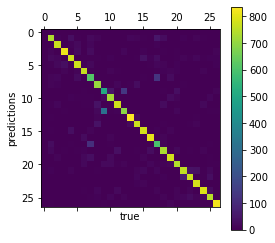

In [39]:
acc, true, pred = test_network(model_early_stopping, combined_test_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model_early_stopping.classes), pred, true)

As hypothesized, the accuracy of our model with early stopping did improve marginally by about 0.5%.

All these computational experiments show that, as defined, our `letterCNN` is actually well defined and supports a good amount of generalization. To get good results, then, we must pick the dataset carefully so that our model generalizes to a variety of handwriting and font styles. 

## Computational Experiment 2 - Architecture

As our second computational experiment, we will visualize the learned kernels of our basic model and then change the architecture to create a new model in hopes of creating a more accurate network. 

### Visualizing previous kernels

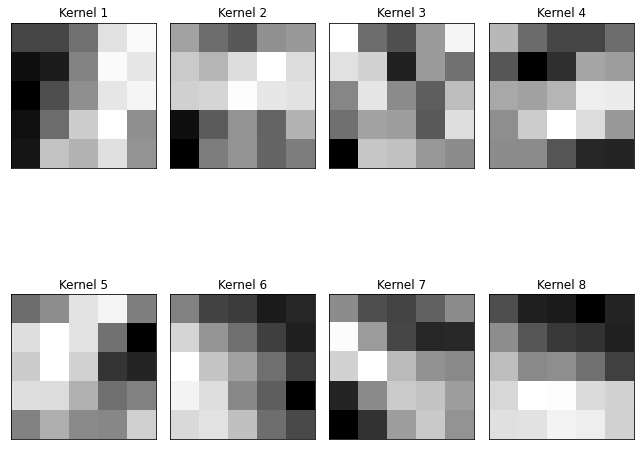

In [40]:
# extract the weights from the learned model
conv1wt = basic_model.layers[0].weight.data.numpy()
display_kernels(conv1wt)

It seems that in our basic model, the kernels are learning to identify specific edge types within letters. For example, in Kernel 8, it seems that the model is learning to identify horizontal edges while in Kernel 1 the model is learning to identify vertical edges. Based upon this, we hypothesize that adding a second convolutional layer to our current model will help it learn the features/characterisitics of each letter better.

### 2a) Double Convolutional Layer

In [41]:
class letterCNNDouble(nn.Module):
    def __init__(self, classes):
        super().__init__()
        self.classes = classes
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(5,5), stride=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=8, out_channels=64, kernel_size=(5,5), stride=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1024, len(self.classes))
        )
            
    def forward(self, x):
        return self.layers(x)

In [42]:
model_double_layer = letterCNNDouble(classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_double_layer.parameters(), lr=1e-3)
train_network(model_double_layer, combined_train_loader, combined_val_loader, criterion, optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 0.91967
   Val loss: 0.50976

EPOCH 1
 Train loss: 0.38980
   Val loss: 0.41976

EPOCH 2
 Train loss: 0.28454
   Val loss: 0.38114

EPOCH 3
 Train loss: 0.23200
   Val loss: 0.35731

EPOCH 4
 Train loss: 0.20395
   Val loss: 0.34234

EPOCH 5
 Train loss: 0.17869
   Val loss: 0.35437

EPOCH 6
 Train loss: 0.16434
   Val loss: 0.34824

EPOCH 7
 Train loss: 0.14626
   Val loss: 0.37184

EPOCH 8
 Train loss: 0.13323
   Val loss: 0.38981

EPOCH 9
 Train loss: 0.12390
   Val loss: 0.36887



Test accuracy: 89.917


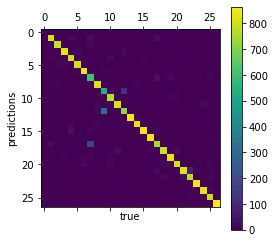

In [43]:
acc, true, pred = test_network(model_double_layer, combined_test_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model_double_layer.classes), pred, true)

As we can see, adding a seecond layer did indeed increase the accuracy by about 5.89% as per our hypothesis.

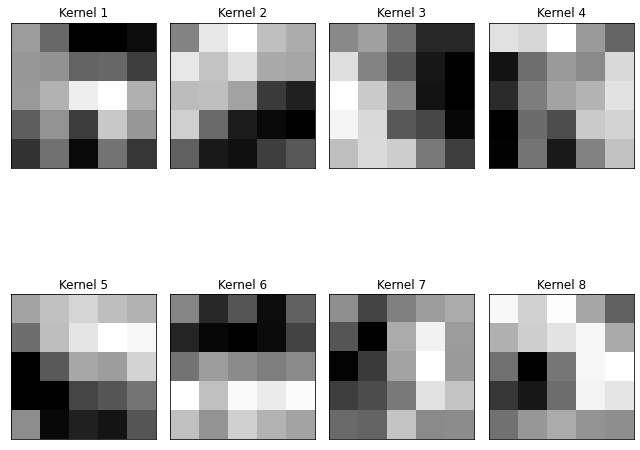

In [44]:
# extract the weights from the learned model
conv2wtsfirst = model_double_layer.layers[0].weight.data.numpy()
display_kernels(conv2wtsfirst)

The first layer is still learning the hard edges of each letter as the single convolutional layer network (i.e. our basic model).

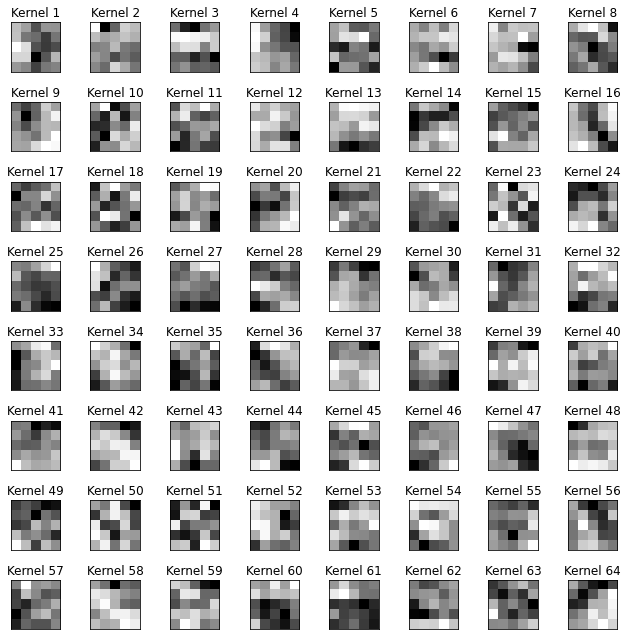

In [45]:
# extract the weights from the learned model
conv2wtssecond = model_double_layer.layers[3].weight.data.numpy()
display_kernels(conv2wtssecond)

As expected, the second layer seems to be learning more precise/specific features. It seems that the second layer is starting to learn more nuances between the edges of each letter - however, that is much harder to confirm. Still, as hypothesized, adding a second convolution layer to our basic CNN helped the new model learn more precise features about each letter and this in turn increased the accuracy of our new model. 

### 2b) Changing the Kernel Size

To better learn how the base model was learning, an optimized input model (built on top of the base CNN) was built. The optimized input model took in an input of all zeros and then optimized this input to reduce the loss (or error) to a specific letter (the letter A, for example). Here are the outputs of the optimized input model for our basic model.

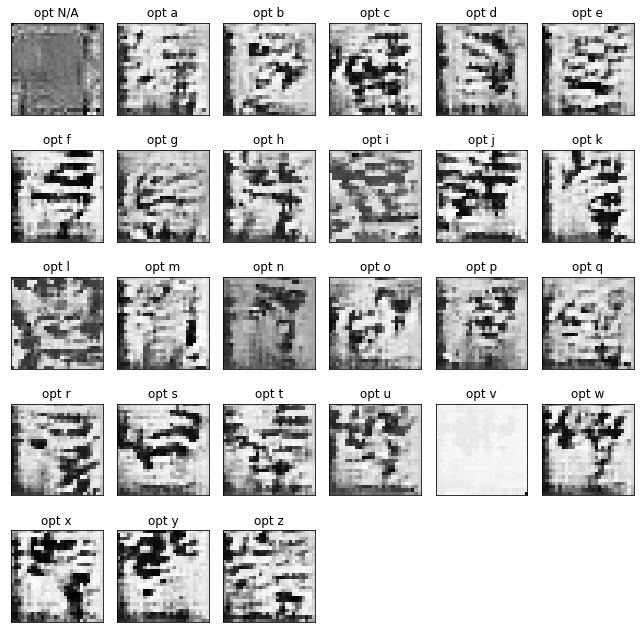

In [47]:
optimized_inputs_kernel_5 = get_optimized_inputs(basic_model, nepochs=1000)
display_optimized_inputs(optimized_inputs_kernel_5)

It can clearly be seen that the optimized input for each letter is different, meaning that our model is learning different features per letter. What those features are specifically, or how the model is learning, is not discernable, however. It can be seen that these learned features are not very smooth (this is also supported from the kernel visualizations of the basic model above). From image processing, we know that smoothing out features can often lead to better results - one way to do this is to alter the kernel size. So, we will alter the kernel size of our model in hopes that the model will better learn the features. Specifically, we hypothesize that increasing the kernel size will allow the model to learn smoother features and therefore more accuractely predict the letters. Reducing the kernel size should have the opposite effect. 

In [48]:
class letterCNNKernel(nn.Module):
    def __init__(self, classes, size):
        super().__init__()
        self.classes = classes
        output_size = (((28 - size) + 1) // 2) ** 2 * 8 
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(size,size), stride=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(output_size, len(self.classes))
        )
            
    def forward(self, x):
        return self.layers(x)

#### Size 3 kernel

In [49]:
model_kernel_3 = letterCNNKernel(classes, 3)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_kernel_3.parameters(), lr=1e-3)
train_network(model_kernel_3, combined_train_loader, combined_val_loader, criterion, optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 1.36918
   Val loss: 1.01998

EPOCH 1
 Train loss: 0.87827
   Val loss: 0.82500

EPOCH 2
 Train loss: 0.70572
   Val loss: 0.75380

EPOCH 3
 Train loss: 0.60972
   Val loss: 0.70805

EPOCH 4
 Train loss: 0.54396
   Val loss: 0.67841

EPOCH 5
 Train loss: 0.49400
   Val loss: 0.66887

EPOCH 6
 Train loss: 0.45732
   Val loss: 0.63970

EPOCH 7
 Train loss: 0.42459
   Val loss: 0.62317

EPOCH 8
 Train loss: 0.39873
   Val loss: 0.62170

EPOCH 9
 Train loss: 0.37801
   Val loss: 0.61132



Test accuracy: 81.652


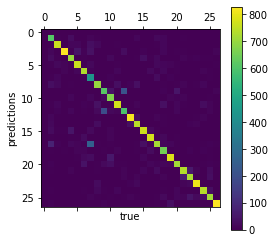

In [50]:
acc, true, pred = test_network(model_kernel_3, combined_test_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model_kernel_3.classes), pred, true)

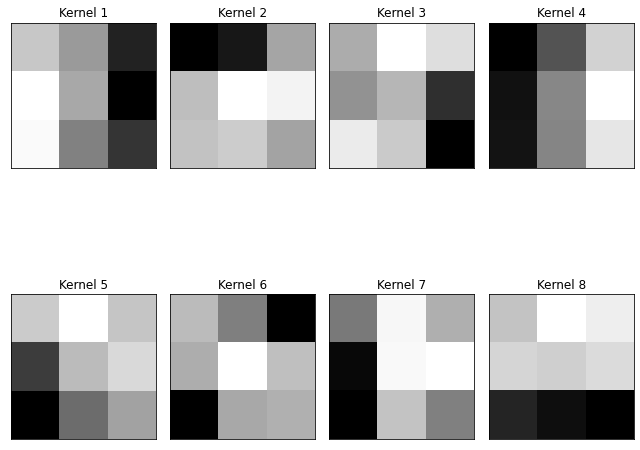

In [51]:
# extract the weights from the learned model
convk3_layer = model_kernel_3.layers[0]
display_kernels(convk3_layer.weight.data.numpy())

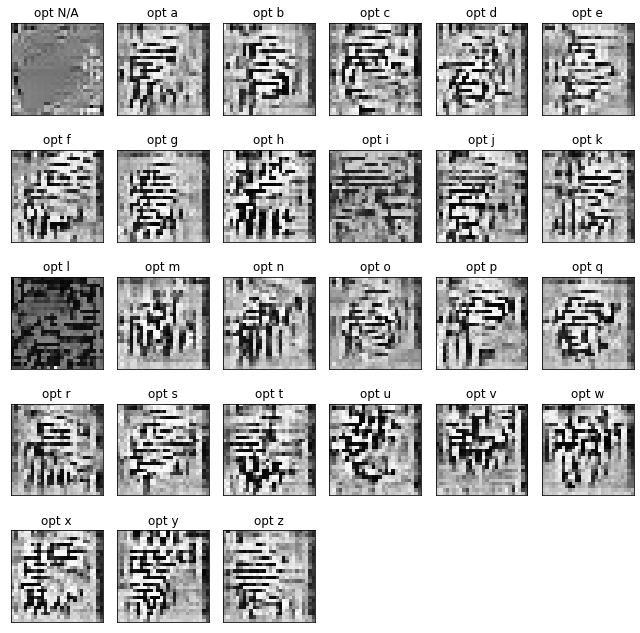

In [52]:
optimized_inputs_kernel_3 = get_optimized_inputs(model_kernel_3, nepochs=1000)
display_optimized_inputs(optimized_inputs_kernel_3)

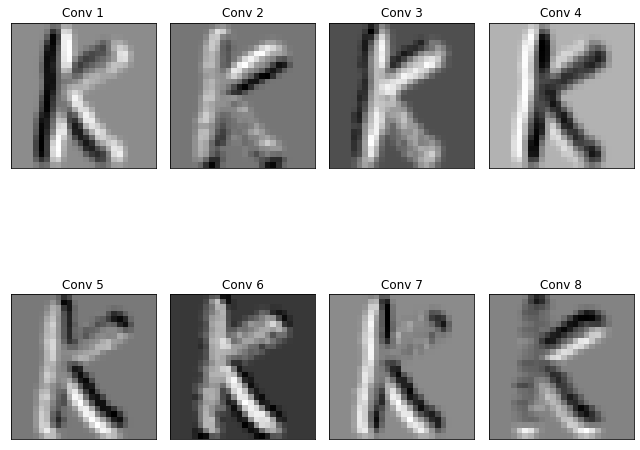

In [53]:
# Visualizing convolved outputs for 3x3 kernel
_ = display_conv_outputs(convk3_layer, img)

As hypothesized, the accuracy of the model with a smaller kernel size did decrease. The optimized input is also less smooth and so are the learned kernels and the convolved kernels. 

#### Size 8 kernel

In [54]:
model_kernel_8 = letterCNNKernel(classes, 8)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_kernel_8.parameters(), lr=1e-3)
train_network(model_kernel_8, combined_train_loader, combined_val_loader, criterion, optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 1.25645
   Val loss: 0.79819

EPOCH 1
 Train loss: 0.66836
   Val loss: 0.64412

EPOCH 2
 Train loss: 0.53421
   Val loss: 0.60742

EPOCH 3
 Train loss: 0.46377
   Val loss: 0.58406

EPOCH 4
 Train loss: 0.41770
   Val loss: 0.57254

EPOCH 5
 Train loss: 0.38396
   Val loss: 0.54469

EPOCH 6
 Train loss: 0.35960
   Val loss: 0.53747

EPOCH 7
 Train loss: 0.33985
   Val loss: 0.53372

EPOCH 8
 Train loss: 0.32368
   Val loss: 0.54994

EPOCH 9
 Train loss: 0.31038
   Val loss: 0.54251



Test accuracy: 84.742


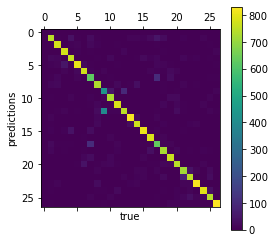

In [55]:
acc, true, pred = test_network(model_kernel_8, combined_test_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model_kernel_8.classes), pred, true)

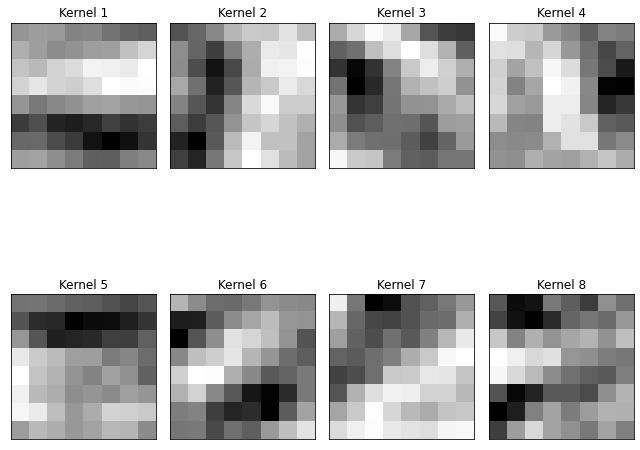

In [56]:
# extract the weights from the learned model
convk8_layer = model_kernel_8.layers[0]
display_kernels(convk8_layer.weight.data.numpy())

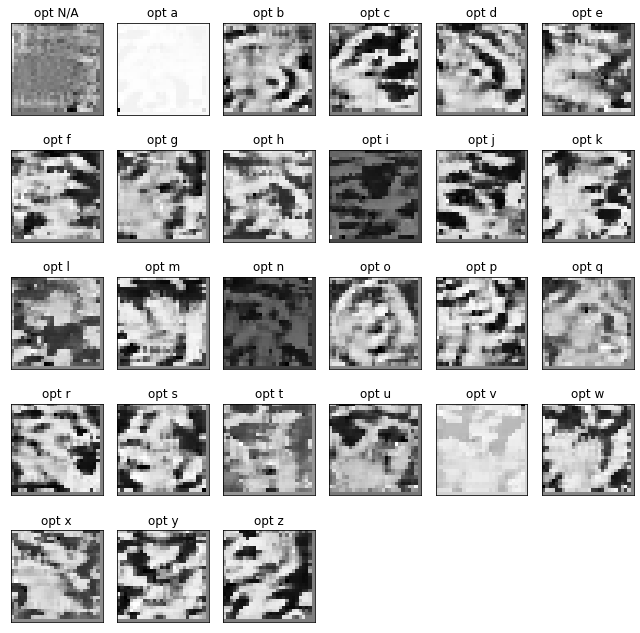

In [57]:
optimized_inputs_kernel_8 = get_optimized_inputs(model_kernel_8, nepochs=1000)
display_optimized_inputs(optimized_inputs_kernel_8)

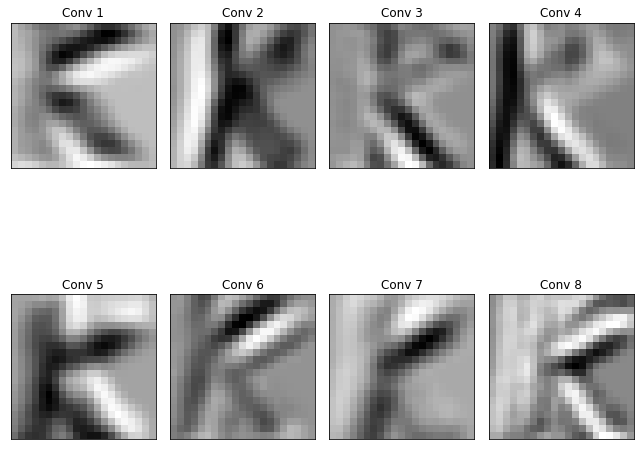

In [58]:
# Visualizing convolved outputs for 8x8 kernel
_ = display_conv_outputs(convk8_layer, img)

As hypothesized, the accuracy of the model with a bigger kernel size did increase (though only marginally). The optimized input, learned kernels, and convolved kernels are also smoother. 

#### Size 11 kernel

In [59]:
model_kernel_11 = letterCNNKernel(classes, 11)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_kernel_11.parameters(), lr=1e-3)
train_network(model_kernel_11, combined_train_loader, combined_val_loader, criterion, optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 1.23866
   Val loss: 0.73132

EPOCH 1
 Train loss: 0.62111
   Val loss: 0.60082

EPOCH 2
 Train loss: 0.49507
   Val loss: 0.55390

EPOCH 3
 Train loss: 0.43385
   Val loss: 0.53675

EPOCH 4
 Train loss: 0.39439
   Val loss: 0.52543

EPOCH 5
 Train loss: 0.36757
   Val loss: 0.52265

EPOCH 6
 Train loss: 0.34580
   Val loss: 0.53674

EPOCH 7
 Train loss: 0.33015
   Val loss: 0.51772

EPOCH 8
 Train loss: 0.31684
   Val loss: 0.50349

EPOCH 9
 Train loss: 0.30714
   Val loss: 0.52818



Test accuracy: 84.781


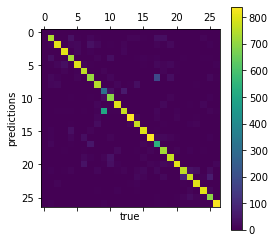

In [60]:
acc, true, pred = test_network(model_kernel_11, combined_test_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model_kernel_11.classes), pred, true)

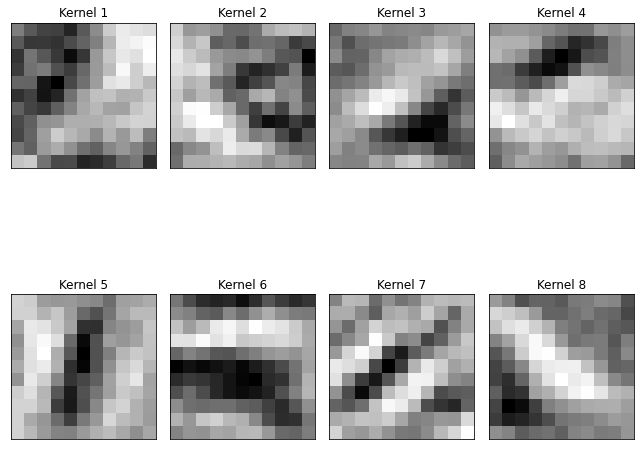

In [61]:
# extract the weights from the learned model
convk11_layer = model_kernel_11.layers[0]
display_kernels(convk11_layer.weight.data.numpy())

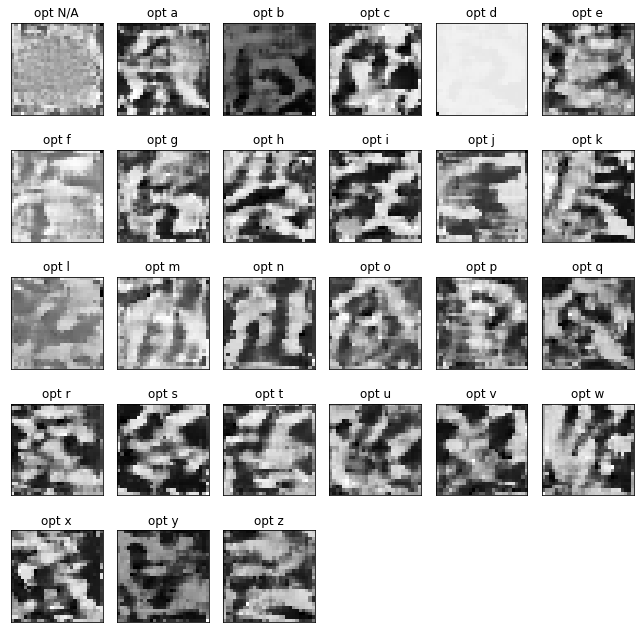

In [62]:
optimized_inputs_kernel_11 = get_optimized_inputs(model_kernel_11, nepochs=1000)
display_optimized_inputs(optimized_inputs_kernel_11)

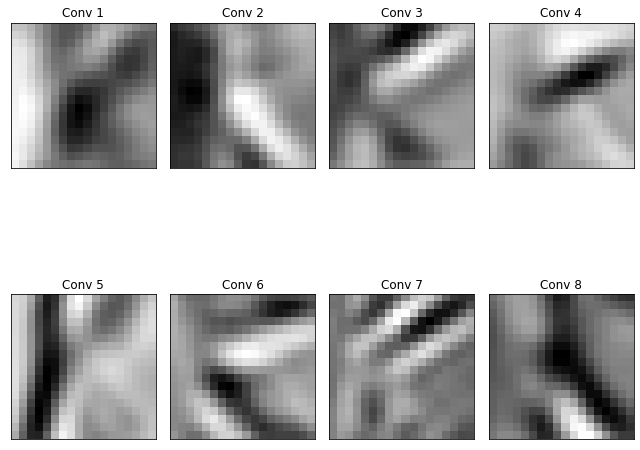

In [63]:
# Visualizing convolved outputs for 11x11 kernel
_ = display_conv_outputs(convk11_layer, img)

Once again, we see an increase in accuracy with a larger kernel (though the increase was only marginal). The optimized input, learned kernels, and convolved kernels were also smoother than the kernel with size 8. 

This shows that using a larger kernel enables a model to learn a smoother set of features. Learning a smoother set of is beneficial since it leads to better accuracy. In this case, we believe that the increase in accuracy was only marginal because the image was quite small to begin with. However, in cases where the images are bigger, or the scenario is just more specialized, using bigger kernel to learn smoother features can lead to a signficant increase in accuracy, even in the realm of letter recognition. 

## Additional Visualizations

We provide some additional visualizations here for reference. 

Label: u


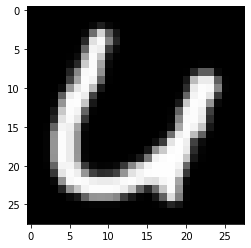

In [59]:
# Visualizing a different letter from the combined dataset
img, label = get_input(combined_train_loader)
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')
print("Label: %s" % classes[label])

#### Single Convolution Layer

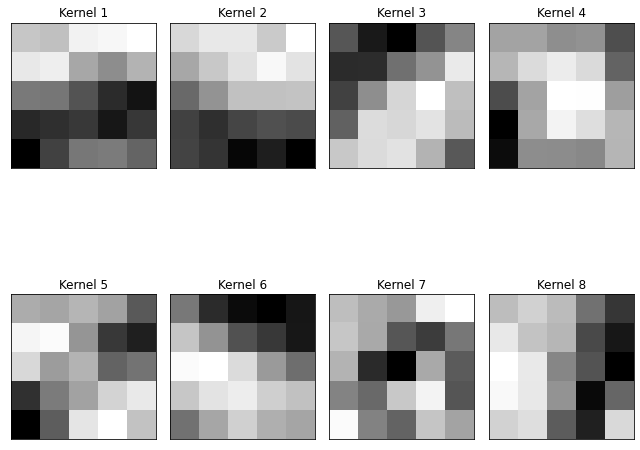

In [60]:
# Visualizing the learned kernels for the single convolutional layer network
conv1_layer = basic_model.layers[0]
display_kernels(conv1_layer.weight.data.numpy())

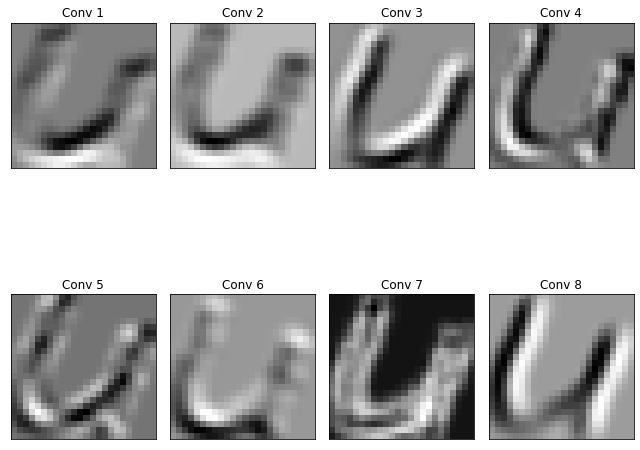

In [61]:
# Visualizing convolved outputs for the single convolutional layer network
conv_outs = display_conv_outputs(conv1_layer, img)

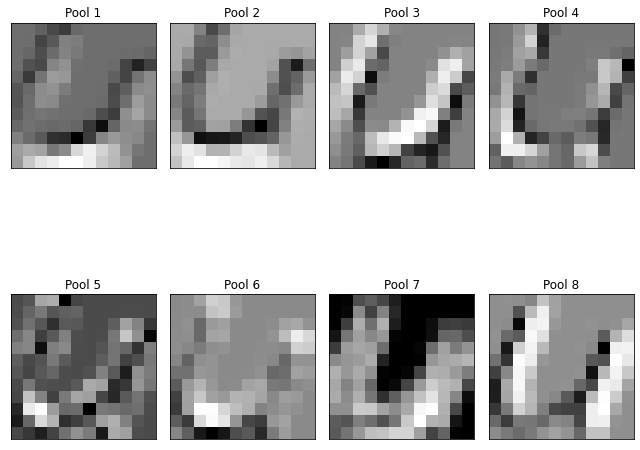

In [62]:
# Visualizing the max pooling layer outputs for the single convolutional layer network
_ = display_pool_outputs(basic_model.layers[1], conv_outs)

#### Double Convolutional Layer

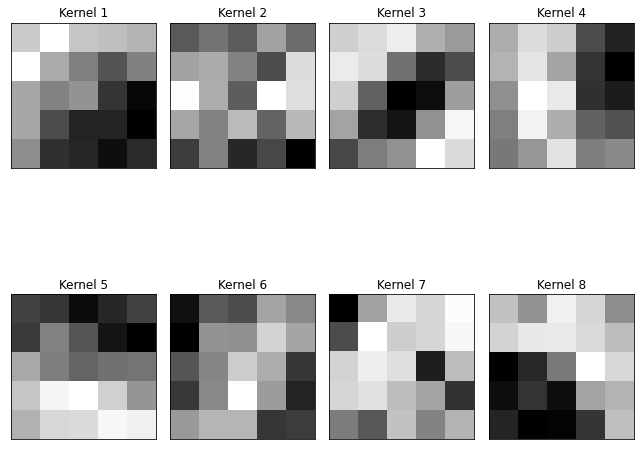

In [63]:
# Visualizing the learned kernels of the first convolution layer of the double convolutional network
conv2_layer1 = model_double_layer.layers[0]
display_kernels(conv2_layer1.weight.data.numpy())

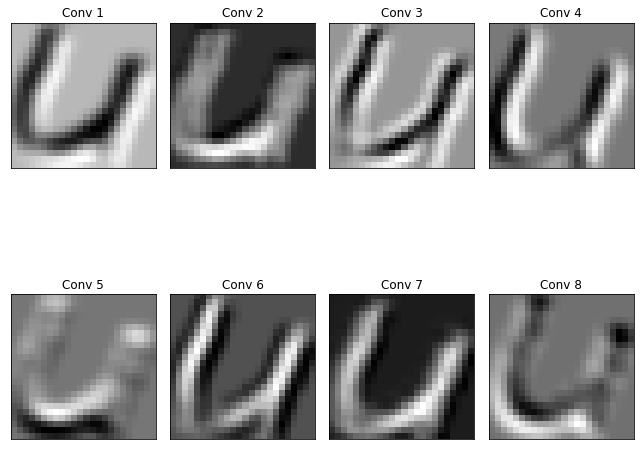

In [64]:
# Visualizing the convolved outputs of first convolution layer of the double convolutional network
outs_layer1 = display_conv_outputs(model_double_layer.layers[0], img)

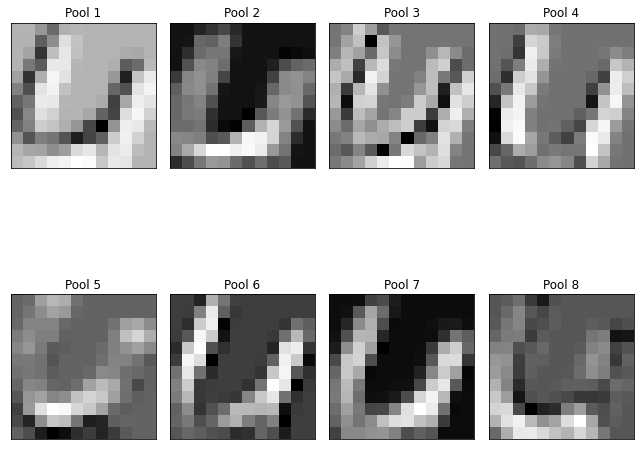

In [65]:
# Visualizing the max pool outputs of the first max pool layer of the double convolutional network
pooled_layer1 = display_pool_outputs(model_double_layer.layers[1], outs_layer1)

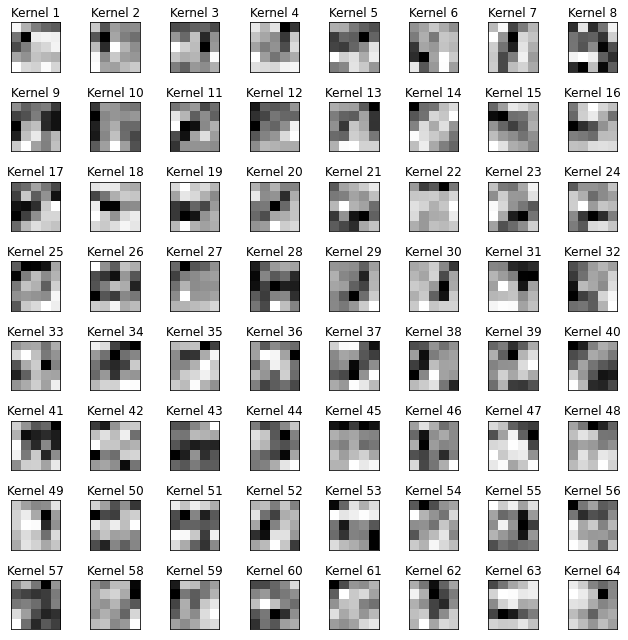

In [66]:
# Visualizing the learned kernels of the second convolution layer of the double convolutional network
conv2_layer2 = model_double_layer.layers[3]
display_kernels(conv2_layer2.weight.data.numpy())

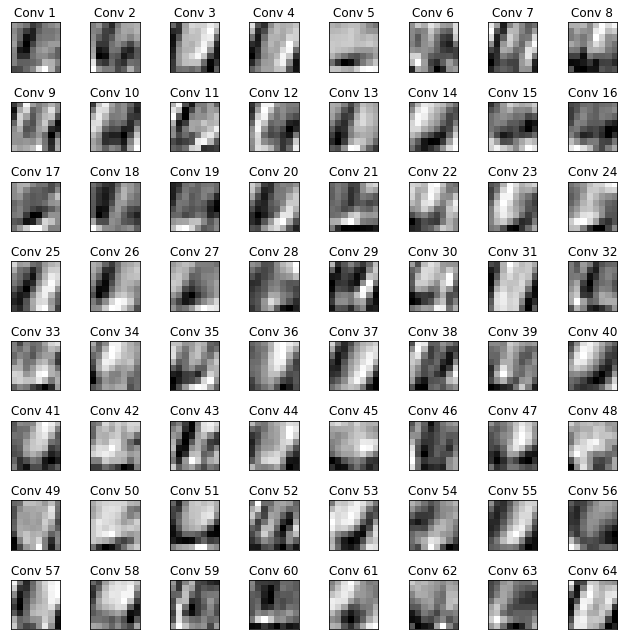

In [67]:
# Visualizing the convolved outputs of the second convolution layer of the double convolutional network
inputs_layer2 = model_double_layer.layers[2](pooled_layer1)
outs_layer2 = display_conv_outputs(model_double_layer.layers[3], inputs_layer2)

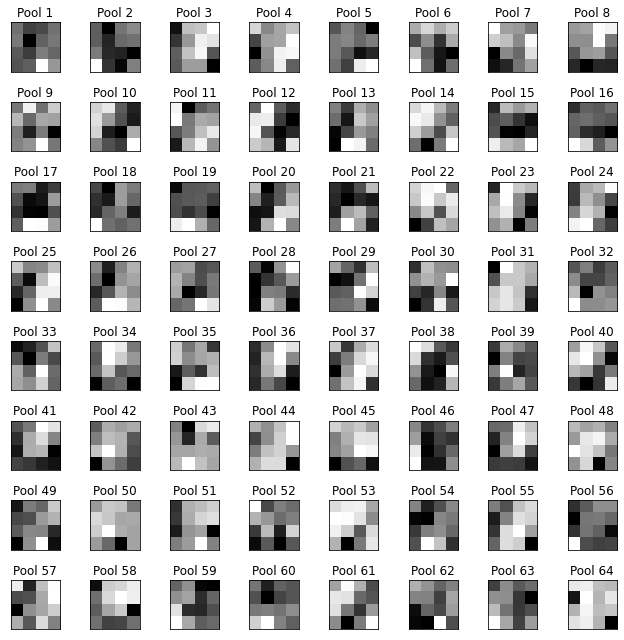

In [68]:
# Visualizing the max pool outputs of second max pool layer of the double convolutional network
_ = display_pool_outputs(model_double_layer.layers[4], outs_layer2)

In [64]:
# Visualizing the optimized inputs of the double convolutional network
optimized_inputs_double_conv = get_optimized_inputs(model_double_layer, nepochs=1000, validate_loss=True)

finished N/A with 0.41583 loss	Expected: N/A. Predicted: N/A.
finished a with 0.00033 loss	Expected: a. Predicted: a.
finished b with 0.00040 loss	Expected: b. Predicted: b.
finished c with 0.00018 loss	Expected: c. Predicted: c.
finished d with 0.00040 loss	Expected: d. Predicted: d.
finished e with 0.00026 loss	Expected: e. Predicted: e.
finished f with 0.00021 loss	Expected: f. Predicted: f.
finished g with 0.00024 loss	Expected: g. Predicted: g.
finished h with 0.00013 loss	Expected: h. Predicted: h.
finished i with 0.00019 loss	Expected: i. Predicted: i.
finished j with 0.00013 loss	Expected: j. Predicted: j.
finished k with 0.00021 loss	Expected: k. Predicted: k.
finished l with 0.00007 loss	Expected: l. Predicted: l.
finished m with 0.00010 loss	Expected: m. Predicted: m.
finished n with 0.00008 loss	Expected: n. Predicted: n.
finished o with 0.00029 loss	Expected: o. Predicted: o.
finished p with 0.00010 loss	Expected: p. Predicted: p.
finished q with 0.00028 loss	Expected: q. 

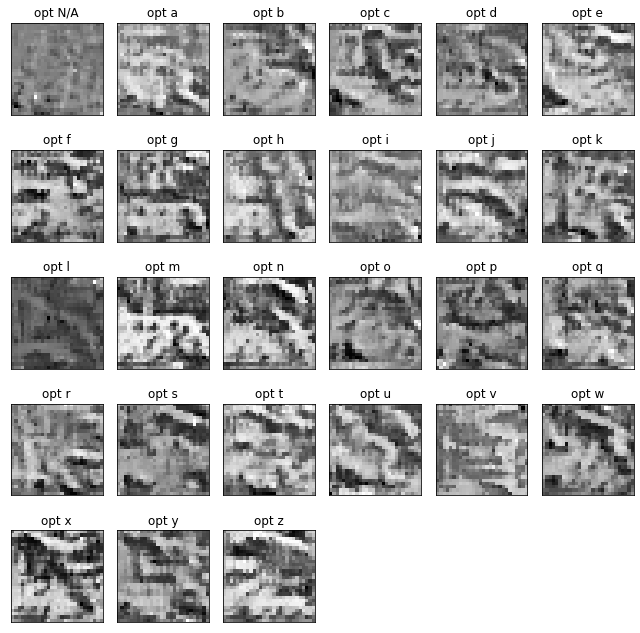

In [65]:
display_optimized_inputs(optimized_inputs_double_conv)